# Statistical Analysis of Irrigation Values Inside and Outside Dam Command Areas (2000 & 2015)

This notebook performs descriptive statistics, visualizations, and hypothesis testing on irrigation pixel values extracted from inside and outside dam command areas for the years 2000 and 2015. The analysis follows advisor feedback and is structured as follows:

**Outline:**
1. Data Loading
2. Descriptive Statistics
3. Distribution Visualization
4. Statistical Hypothesis Testing

---

In [ ]:
# Task 1: Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind
import os
import sys
from tqdm import tqdm
import warnings 
from IPython.display import display, Markdown
from itertools import product
warnings.filterwarnings('ignore')

# Add the project root to sys.path so we can import from Code.utils everywhere
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from Code.utils.utility import load_config, resolve_path, ssa_iso, africa_iso_countries, africa_iso_countries_filtered
from Code.utils.spatial_utility import load_and_reproject, optimized_clip

# Load configuration
config = load_config()

# Load the four CSV files using resolve_path and config (for consistency with project I/O)
inside_2000 = pd.read_csv(resolve_path(config['Irrigation_Inside_CA_2000_csv_path']))
outside_2000 = pd.read_csv(resolve_path(config['Irrigation_Outside_CA_2000_csv_path']))
inside_2015 = pd.read_csv(resolve_path(config['Irrigation_Inside_CA_2015_csv_path']))
outside_2015 = pd.read_csv(resolve_path(config['Irrigation_Outside_CA_2015_csv_path']))

# Ensure the column is named 'irrigation_value'
for df in [inside_2000, outside_2000, inside_2015, outside_2015]:
    if 'irrigation_value' not in df.columns:
        df.columns = ['irrigation_value']

print('Data loaded successfully. Sample rows:')
print('Inside 2000:', inside_2000.head(3), sep='\n')
print('Outside 2000:', outside_2000.head(3), sep='\n')
print('Inside 2015:', inside_2015.head(3), sep='\n')
print('Outside 2015:', outside_2015.head(3), sep='\n')

Data loaded successfully. Sample rows:
Inside 2000:
   irrigation_value
0               0.0
1               0.0
2               0.0
Outside 2000:
   irrigation_value
0               0.0
1               0.0
2               0.0
Inside 2015:
   irrigation_value
0               0.0
1               0.0
2               0.0
Outside 2015:
   irrigation_value
0               0.0
1               0.0
2               0.0


## Task 2: Descriptive Statistics
For each group (inside/outside, 2000/2015), we calculate mean, median, standard deviation, variance, min, max, and quartiles. Variance is highlighted as a key metric.

In [15]:
def print_descriptive_stats(df, label):
    desc = df['irrigation_value'].describe(percentiles=[0.25, 0.75])
    variance = df['irrigation_value'].var()
    print(f'--- Descriptive Statistics for {label} ---')
    print(f'Mean: {desc["mean"]:.4f}')
    print(f'Median: {desc["50%"]:.4f}')
    print(f'Std Dev: {desc["std"]:.4f}')
    print(f'Variance: {variance:.4f}')
    print(f'Min: {desc["min"]:.4f}')
    print(f'Q1 (25th): {desc["25%"]:.4f}')
    print(f'Q3 (75th): {desc["75%"]:.4f}')
    print(f'Max: {desc["max"]:.4f}')
    print()

print_descriptive_stats(inside_2000, 'Irrigation Inside Polygons - 2000')
print_descriptive_stats(outside_2000, 'Irrigation Outside Polygons - 2000')
print_descriptive_stats(inside_2015, 'Irrigation Inside Polygons - 2015')
print_descriptive_stats(outside_2015, 'Irrigation Outside Polygons - 2015')

--- Descriptive Statistics for Irrigation Inside Polygons - 2000 ---
Mean: 14.1899
Median: 0.0000
Std Dev: 184.1855
Variance: 33924.2932
Min: 0.0000
Q1 (25th): 0.0000
Q3 (75th): 0.0000
Max: 5426.1510

--- Descriptive Statistics for Irrigation Outside Polygons - 2000 ---
Mean: 17.0499
Median: 0.0000
Std Dev: 203.1722
Variance: 41278.9312
Min: 0.0000
Q1 (25th): 0.0000
Q3 (75th): 0.0000
Max: 5426.1510

--- Descriptive Statistics for Irrigation Inside Polygons - 2015 ---
Mean: 14.8556
Median: 0.0000
Std Dev: 175.7614
Variance: 30892.0867
Min: 0.0000
Q1 (25th): 0.0000
Q3 (75th): 0.0000
Max: 5426.1510

--- Descriptive Statistics for Irrigation Outside Polygons - 2015 ---
Mean: 17.6309
Median: 0.0000
Std Dev: 201.6800
Variance: 40674.8402
Min: 0.0000
Q1 (25th): 0.0000
Q3 (75th): 0.0000
Max: 5426.1510



In [ ]:

# 1. Filter for nonzero irrigation pixels
inside_2000_nz = inside_2000[inside_2000['irrigation_value'] > 0]
outside_2000_nz = outside_2000[outside_2000['irrigation_value'] > 0]
inside_2015_nz = inside_2015[inside_2015['irrigation_value'] > 0]
outside_2015_nz = outside_2015[outside_2015['irrigation_value'] > 0]

print('Sample sizes:')
print(f'2000: Inside={len(inside_2000)}, Outside={len(outside_2000)}, Inside nonzero={len(inside_2000_nz)}, Outside nonzero={len(outside_2000_nz)}')
print(f'2015: Inside={len(inside_2015)}, Outside={len(outside_2015)}, Inside nonzero={len(inside_2015_nz)}, Outside nonzero={len(outside_2015_nz)}')


Sample sizes:
2000: Inside=3712, Outside=5694, Inside nonzero=125, Outside nonzero=195
2015: Inside=3712, Outside=5694, Inside nonzero=124, Outside nonzero=192
--- 2000 (all pixels) ---
Mean (Inside): 14.1899 | Mean (Outside): 17.0499
Median (Inside): 0.0000 | Median (Outside): 0.0000

--- 2015 (all pixels) ---
Mean (Inside): 14.8556 | Mean (Outside): 17.6309
Median (Inside): 0.0000 | Median (Outside): 0.0000

--- 2000 (nonzero pixels) ---
Mean (Inside): 421.3834 | Mean (Outside): 497.8570
Median (Inside): 74.7999 | Median (Outside): 123.0908

--- 2015 (nonzero pixels) ---
Mean (Inside): 444.7108 | Mean (Outside): 522.8658
Median (Inside): 127.1436 | Median (Outside): 143.7090



In [ ]:
# Table of summary statistics
def summary_table():
    rows = []
    for label, df in [("2000 Inside", inside_2000), ("2000 Outside", outside_2000),
                    ("2015 Inside", inside_2015), ("2015 Outside", outside_2015),
                    ("2000 Inside Nonzero", inside_2000_nz), ("2000 Outside Nonzero", outside_2000_nz),
                    ("2015 Inside Nonzero", inside_2015_nz), ("2015 Outside Nonzero", outside_2015_nz)]:
        rows.append({
            "Group": label,
            "Mean": df["irrigation_value"].mean(),
            "Median": df["irrigation_value"].median(),
            "Variance": df["irrigation_value"].var()
        })
    return pd.DataFrame(rows)

display(Markdown("### Summary Table: Mean, Median, Variance"))
display(summary_table())

## Task 3: Distribution Visualization
We plot histograms and KDEs for inside and outside groups for each year. Both distributions are shown on the same axes for direct comparison.

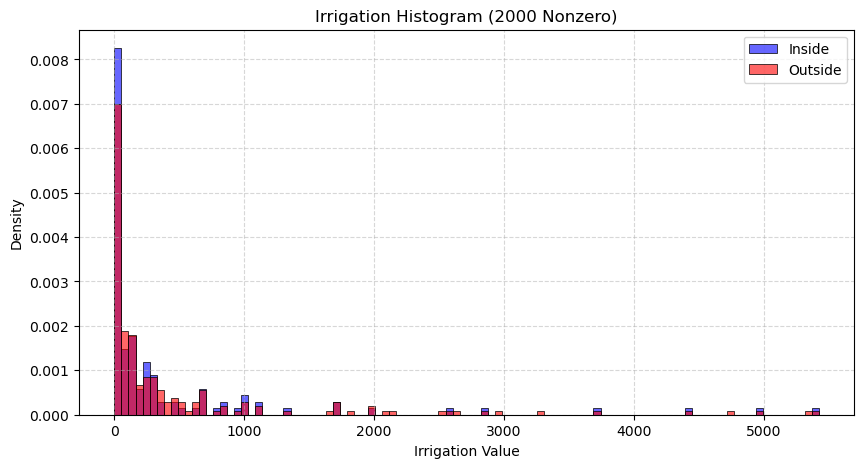

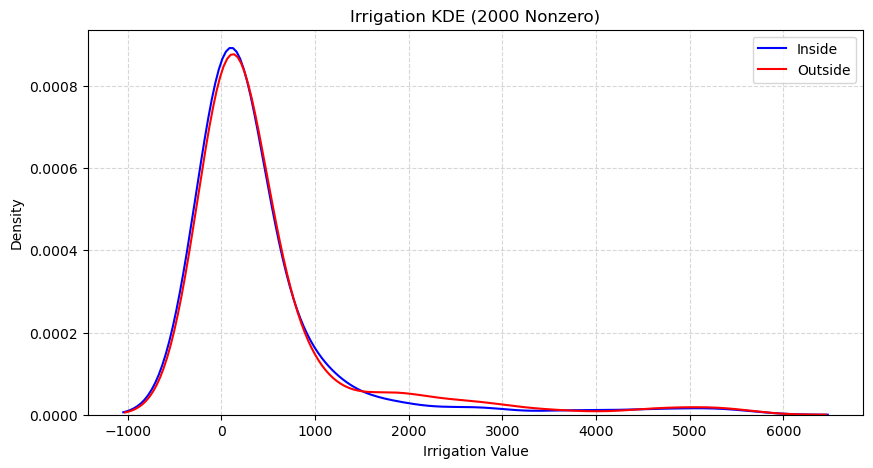

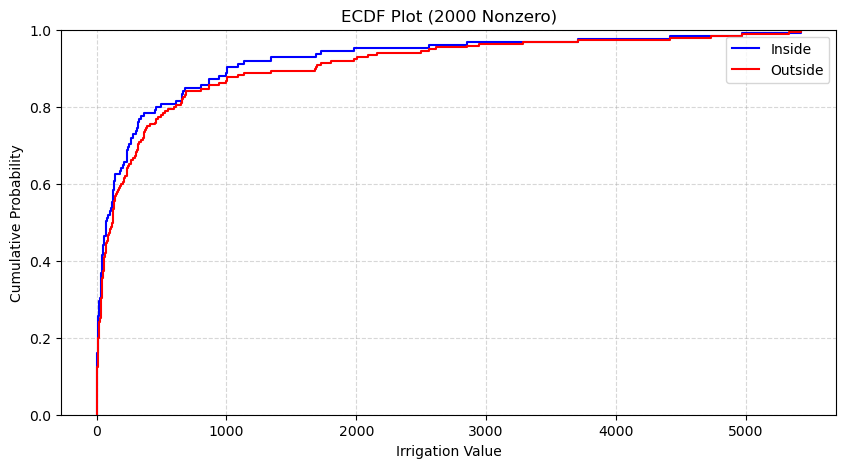

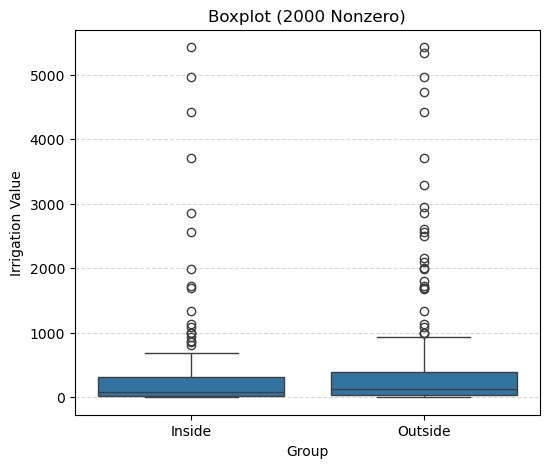

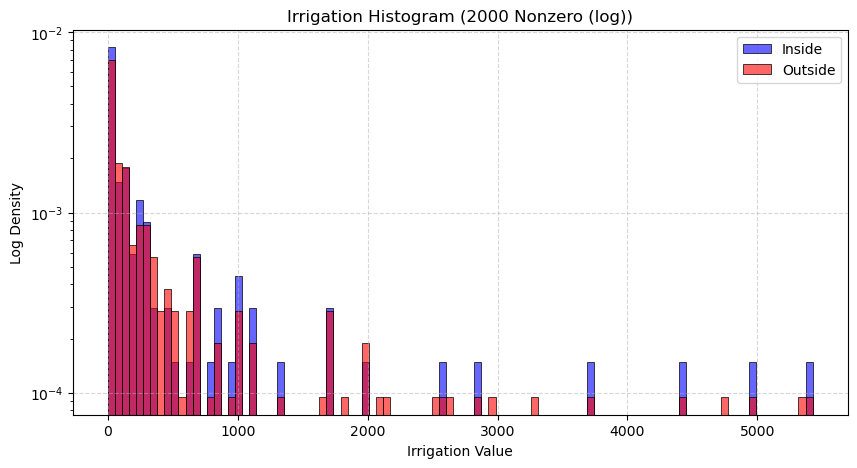

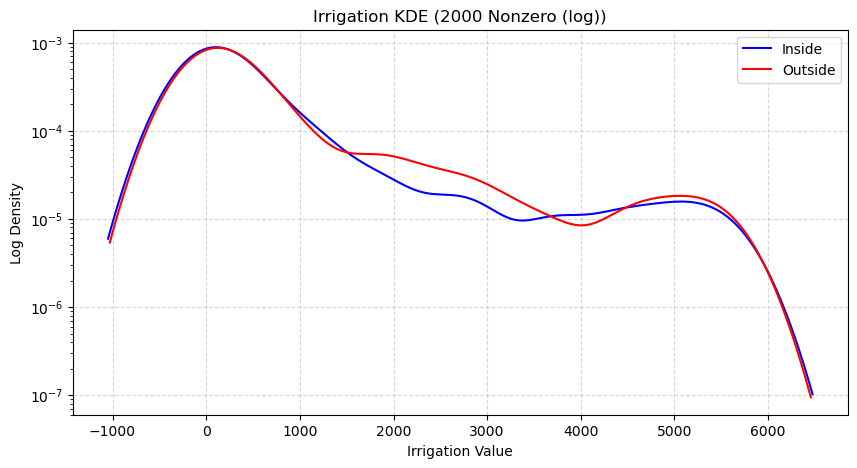

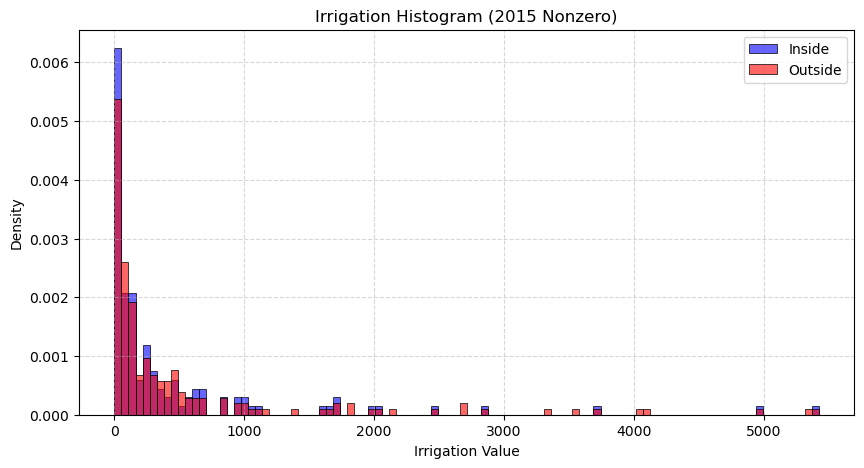

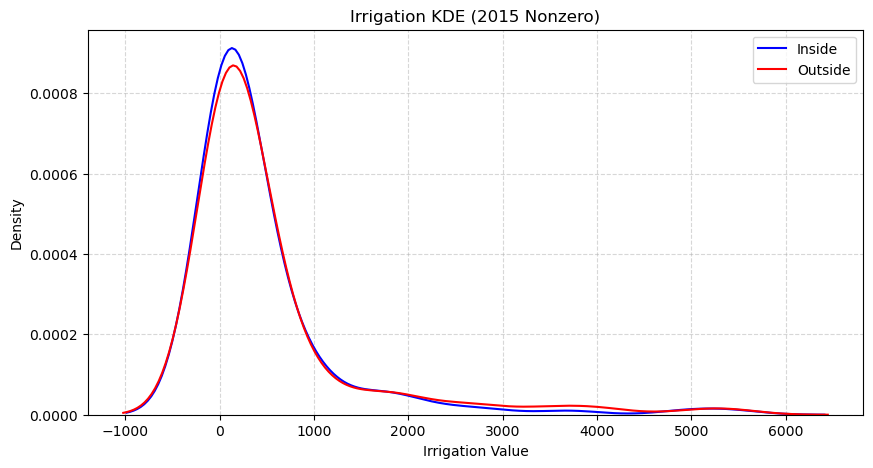

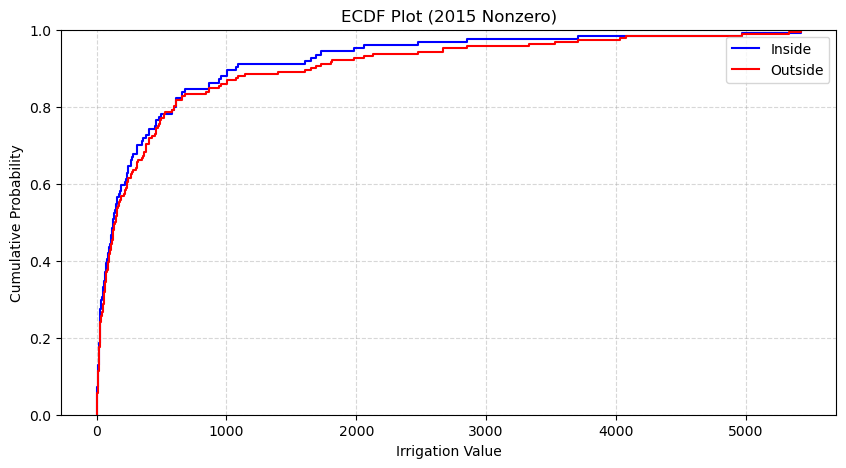

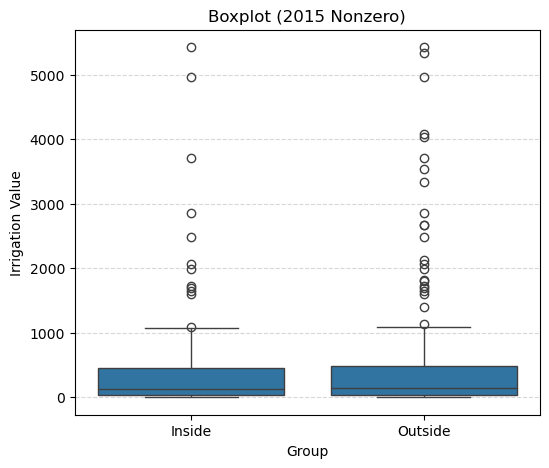

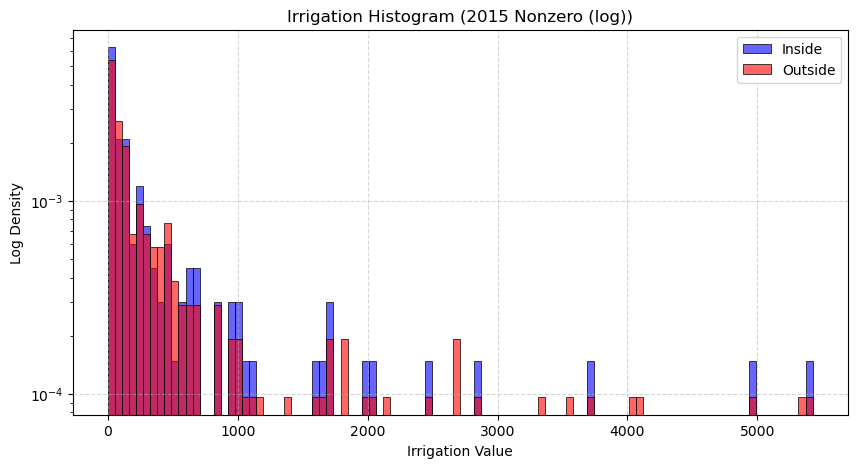

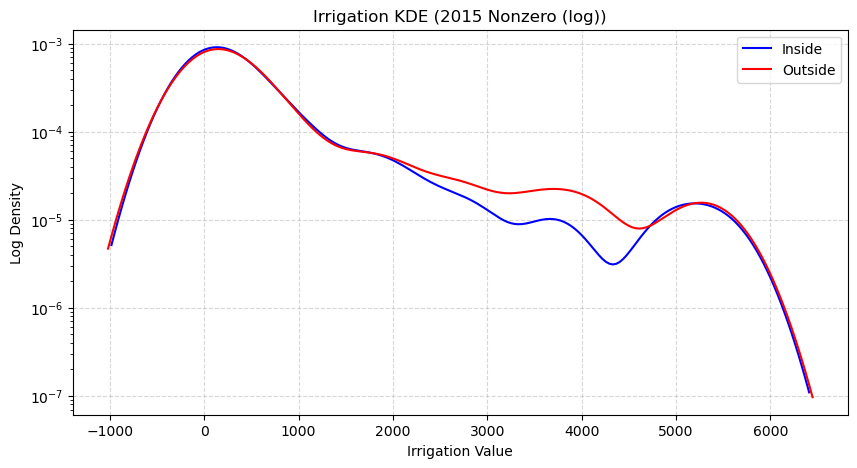

In [22]:
# Histogram Plot
def plot_histogram(df_in, df_out, label, log_scale=False):
    plt.figure(figsize=(10, 5))
    sns.histplot(df_in['irrigation_value'], stat="density", bins=100, color='blue', label='Inside', alpha=0.6)
    sns.histplot(df_out['irrigation_value'], stat="density", bins=100, color='red', label='Outside', alpha=0.6)
    plt.title(f'Irrigation Histogram ({label})')
    plt.xlabel("Irrigation Value")
    plt.ylabel("Density" if not log_scale else "Log Density")
    plt.legend()
    if log_scale:
        plt.yscale("log")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# KDE Plot
def plot_kde(df_in, df_out, label, log_scale=False):
    plt.figure(figsize=(10, 5))
    sns.kdeplot(df_in['irrigation_value'], label='Inside', color='blue')
    sns.kdeplot(df_out['irrigation_value'], label='Outside', color='red')
    plt.title(f'Irrigation KDE ({label})')
    plt.xlabel("Irrigation Value")
    plt.ylabel("Density" if not log_scale else "Log Density")
    plt.legend()
    if log_scale:
        plt.yscale("log")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# ECDF Plot
def plot_ecdf(df_in, df_out, label):
    plt.figure(figsize=(10, 5))
    sns.ecdfplot(df_in['irrigation_value'], label='Inside', color='blue')
    sns.ecdfplot(df_out['irrigation_value'], label='Outside', color='red')
    plt.title(f'ECDF Plot ({label})')
    plt.xlabel("Irrigation Value")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# Boxplot
def plot_boxplot(df_in, df_out, label):
    combined_df = pd.concat([
        df_in.assign(Group='Inside'),
        df_out.assign(Group='Outside')
    ])
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=combined_df, x='Group', y='irrigation_value')
    plt.title(f'Boxplot ({label})')
    plt.ylabel("Irrigation Value")
    plt.grid(True, axis='y', linestyle="--", alpha=0.5)
    plt.show()

# === 2000 Nonzero ===
plot_histogram(inside_2000_nz, outside_2000_nz, "2000 Nonzero", log_scale=False)
plot_kde(inside_2000_nz, outside_2000_nz, "2000 Nonzero", log_scale=False)
plot_ecdf(inside_2000_nz, outside_2000_nz, "2000 Nonzero")
plot_boxplot(inside_2000_nz, outside_2000_nz, "2000 Nonzero")

# Optional: log-scaled versions (helpful to highlight heavy tails)
plot_histogram(inside_2000_nz, outside_2000_nz, "2000 Nonzero (log)", log_scale=True)
plot_kde(inside_2000_nz, outside_2000_nz, "2000 Nonzero (log)", log_scale=True)
# plot_ecdf(inside_2000_nz, outside_2000_nz, "2000 Nonzero (log)")  # often redundant
# plot_boxplot(inside_2000_nz, outside_2000_nz, "2000 Nonzero (log)")  # redundant

# === 2015 Nonzero ===
plot_histogram(inside_2015_nz, outside_2015_nz, "2015 Nonzero", log_scale=False)
plot_kde(inside_2015_nz, outside_2015_nz, "2015 Nonzero", log_scale=False)
plot_ecdf(inside_2015_nz, outside_2015_nz, "2015 Nonzero")
plot_boxplot(inside_2015_nz, outside_2015_nz, "2015 Nonzero")

# Optional: log-scaled versions
plot_histogram(inside_2015_nz, outside_2015_nz, "2015 Nonzero (log)", log_scale=True)
plot_kde(inside_2015_nz, outside_2015_nz, "2015 Nonzero (log)", log_scale=True)
# plot_ecdf(inside_2015_nz, outside_2015_nz, "2015 Nonzero (log)")
# plot_boxplot(inside_2015_nz, outside_2015_nz, "2015 Nonzero (log)")

# === Optional: All-pixel comparisons ===
# These are noisier due to many zeros and were deemed less informative

# plot_histogram(inside_2000, outside_2000, "2000", log_scale=False)
# plot_kde(inside_2000, outside_2000, "2000", log_scale=False)
# plot_ecdf(inside_2000, outside_2000, "2000")
# plot_boxplot(inside_2000, outside_2000, "2000")

# plot_histogram(inside_2015, outside_2015, "2015", log_scale=False)
# plot_kde(inside_2015, outside_2015, "2015", log_scale=False)
# plot_ecdf(inside_2015, outside_2015, "2015")
# plot_boxplot(inside_2015, outside_2015, "2015")



## Task 4: Statistical Hypothesis Testing
We use the Mann-Whitney U test to formally compare the distributions of irrigation values inside and outside polygons for each year.

**Null Hypothesis (H0):** The distributions of irrigation values inside and outside polygons are the same.

**Alternative Hypothesis (Ha):** The distributions are different.

In [ ]:
def cliffs_delta(a, b):
    n1, n2 = len(a), len(b)
    greater = sum(x > y for x, y in product(a, b))
    less = sum(x < y for x, y in product(a, b))
    return (greater - less) / (n1 * n2)

def run_tests_with_summary(df_in, df_out, label):
    mw_u, mw_p = mannwhitneyu(df_in['irrigation_value'], df_out['irrigation_value'], alternative='two-sided')
    t_stat, t_p = ttest_ind(df_in['irrigation_value'], df_out['irrigation_value'], equal_var=False)
    delta = cliffs_delta(df_in['irrigation_value'], df_out['irrigation_value'])
    conclusion = "Statistically significant" if mw_p < 0.05 or t_p < 0.05 else "No significant difference"
    
    # Console output
    print(f'--- {label} ---')
    print(f'Mann–Whitney U: U={mw_u:.2f}, p={mw_p:.4f}')
    print(f'T-test: t={t_stat:.2f}, p={t_p:.4f}')
    print(f"Cliff's delta: {delta:.4f}")
    print("Conclusion:", conclusion, "\n")

# Run tests and print summaries for all pairs
pairs = [
    (inside_2000, outside_2000, "2000 (All Pixels)"),
    (inside_2015, outside_2015, "2015 (All Pixels)"),
    (inside_2000_nz, outside_2000_nz, "2000 (Nonzero Pixels)"),
    (inside_2015_nz, outside_2015_nz, "2015 (Nonzero Pixels)")
]

for df_in, df_out, label in pairs:
    run_tests_with_summary(df_in, df_out, label)



--- 2000 (All Pixels) ---
Mann–Whitney U: U=10561069.00, p=0.8626
T-test: t=-0.71, p=0.4799
Cliff's delta: -0.0007
Conclusion: No significant difference 

--- 2015 (All Pixels) ---
Mann–Whitney U: U=10564208.00, p=0.9236
T-test: t=-0.71, p=0.4804
Cliff's delta: -0.0004
Conclusion: No significant difference 

--- 2000 (Nonzero Pixels) ---
Mann–Whitney U: U=11237.50, p=0.2396
T-test: t=-0.71, p=0.4805
Cliff's delta: -0.0779
Conclusion: No significant difference 

--- 2015 (Nonzero Pixels) ---
Mann–Whitney U: U=11372.00, p=0.5027
T-test: t=-0.75, p=0.4546
Cliff's delta: -0.0447
Conclusion: No significant difference 



### Summary Table: Mean, Median, Variance

,Group,Mean,Median,Variance
0,2000 Inside,14.189905,0.000000,33924.293230
1,2000 Outside,17.049898,0.000000,41278.931160
2,2015 Inside,14.855642,0.000000,30892.086670
3,2015 Outside,17.630882,0.000000,40674.840177
4,2000 Inside Nonzero,421.383417,74.799880,842298.209496
5,2000 Outside Nonzero,497.857026,123.090800,970738.039826
6,2015 Inside Nonzero,444.710820,127.143565,739321.453360
7,2015 Outside Nonzero,522.865849,143.708970,946812.586314
